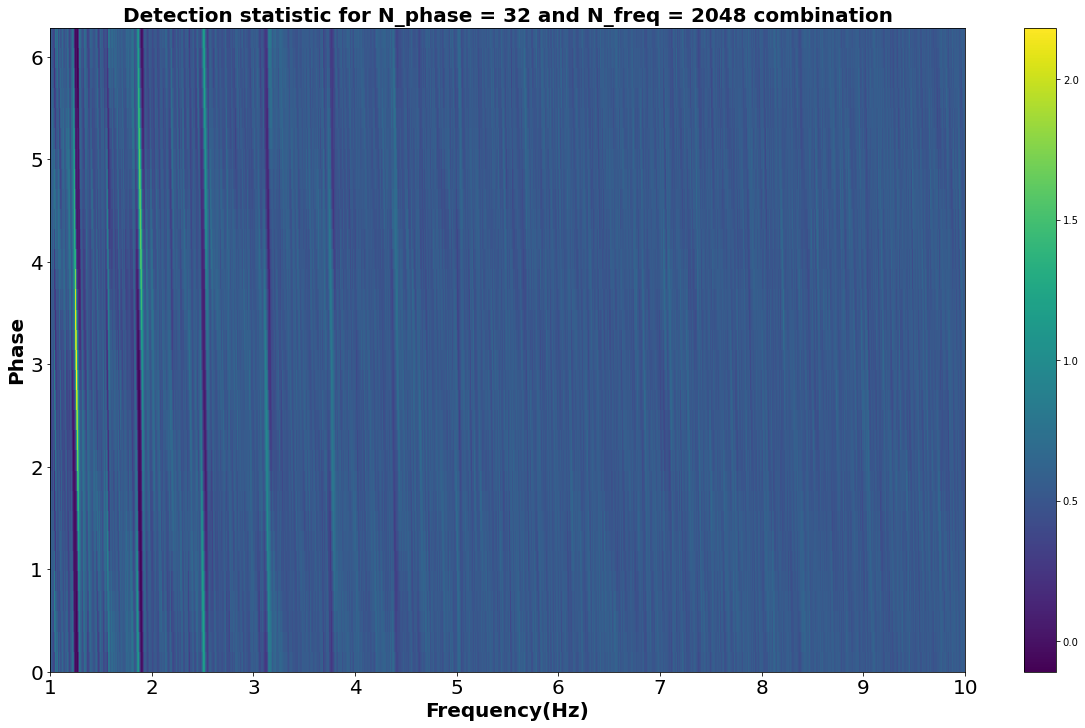

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

class DetectionStatistic:
    def __init__(self, low_limit_freq, up_limit_freq, N_phi, N_w, data_path):
        self.low_limit_freq = low_limit_freq
        self.up_limit_freq = up_limit_freq
        self.N_phi = N_phi
        self.N_w = N_w

        self.phase_list = []
        self.freq_list = []
        self.det_stat_list = []

        self.duty_cycle = 0.1
        self.acceleration = 0
        
        df = pd.read_csv(data_path, delimiter='    ')
        self.time = np.array(df['time_sec'])
        self.datastream = np.array(df['intensity'])
        self.sample_time = df['time_sec'][1] - df['time_sec'][0]

    def pulse_phase(self, p0, t, w0):    
        """
        Calculates and returns pulse phase at any given time 't' when acceleration 'a', initial 
        phase 'p0' and angular frequency 'w0' are known.
        """
        phase = np.array(p0 + w0 * t + 0.5 * self.acceleration * t ** 2)
        return phase

    def von_mises_profile(self, phase_angle):
        """
        Calculates von Mises profile based on duty cycle obtained from previous kappa function.
        For the value of pulse_phase it makes a call from pulse_phase function defined above.
        """
        k = (np.log(2)) / (2 * (np.sin((np.pi * self.duty_cycle) / 2)) ** 2)
        y = np.exp(-2 * k * (np.sin(phase_angle / 2)) ** 2)
        return y
    
    def detection_statistic(self, phaseangle):
        """
        Calculates the detection statistic. Function arguments are data timestream and intensity 
        timestream that we supply as lists. d_k is intensity data in the table above and 
        I_k is von_mises profile calculated for various phase angles. Phase angle itself is 
        calculated from pulse_phase function for the time series.
        """
        I_k = self.von_mises_profile(phaseangle)
        eta_neg_sqr = 1 / (self.sample_time * (np.sum(I_k ** 2)))
        det_stat = eta_neg_sqr * self.sample_time * (np.sum(self.datastream * I_k))
        return det_stat
    
    def run_detection(self):
        ''' Will do the calculation for detection static for a given pair of phase and frequency. Phase
        , frequency and Detection statistics will be stored in a csv file. Can output csv file if line below
        is uncommented as informed.'''
        rest_phase = np.linspace(0, np.pi*2, self.N_phi)
        freq = np.linspace(self.low_limit_freq, self.up_limit_freq, self.N_w)
        
        for ind1 in np.arange(len(rest_phase)):
            p0_val = rest_phase[ind1]
            for ind2 in np.arange(len(freq)):
                freq_value = freq[ind2]
                self.phase_list.append(round(p0_val, 4))
                self.freq_list.append(round(freq_value, 4))
                phase_val = self.pulse_phase(p0_val, self.time, freq_value)
                det_stat_val = self.detection_statistic(phase_val)
                self.det_stat_list.append(det_stat_val)
        
        data = {'Phase': self.phase_list, 'Frequency': self.freq_list, 'Detection Statistic': self.det_stat_list}
        phasefreqdf = pd.DataFrame(data, index=np.arange(len(self.det_stat_list)))
        
        # Uncomment line below if you want a csv file of the detection statistic for phase frequency combination

        phasefreqdf.to_csv('Det_stat_for_N_phi=' + str(self.N_phi) + 'Nw_=' + str(self.N_w), sep= '\t', mode = 'w', columns=['Phase','Frequency','Detection Statistic'], header = ['Phase','Frequency','Detection Statistic'], index=False)
        self.plot_detection_statistic(phasefreqdf)
        
    def plot_detection_statistic(self, phasefreq_df):
        fig, phasefreqmap = plt.subplots(figsize=(15, 10), layout='constrained')
        X = np.linspace(self.low_limit_freq, self.up_limit_freq, self.N_w + 1)
        Y = np.linspace(0, 2 * np.pi, self.N_phi + 1)
        Z = np.array(phasefreq_df['Detection Statistic']).reshape(self.N_phi, self.N_w)
        pcm = phasefreqmap.pcolormesh(X, Y, Z, vmin=Z.min(), vmax=Z.max())
        phasefreqmap.set_xlabel('Frequency(Hz)', fontweight='bold', fontsize=20)
        phasefreqmap.set_ylabel('Phase', fontweight='bold', fontsize=20)
        phasefreqmap.yaxis.set_tick_params(labelsize=20)
        phasefreqmap.xaxis.set_tick_params(labelsize=20)
        phasefreqmap.set_title('Detection statistic for N_phase = {} and N_freq = {} combination'.format(self.N_phi, self.N_w), fontweight='bold', fontsize=20)
        fig.colorbar(pcm, ax=phasefreqmap)
        plt.savefig('/home/astroguy/Desktop/det_stat_case_N_phase = {}_and_N_freq = {}.pdf'.format(self.N_phi, self.N_w))  # Only if you want to save your figure.
        plt.show()

# Example usage:

det_stat = DetectionStatistic(low_limit_freq=1, up_limit_freq=10, N_phi=32, N_w=2048, data_path='/home/astroguy/Desktop/research/research_emannuele/init_coh_search_algthm/sim_pulse_03.txt')
det_stat.run_detection()